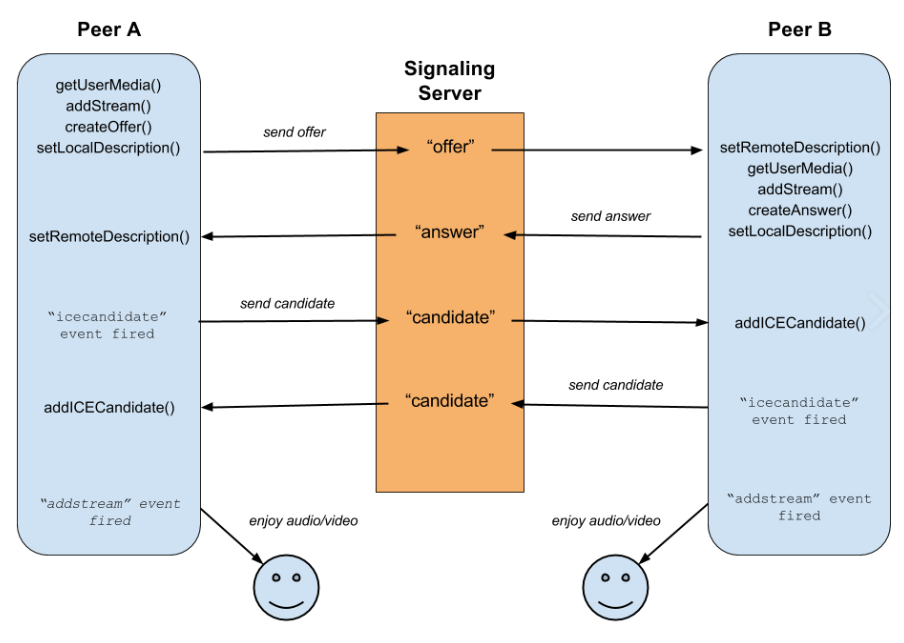

# 

---

# 

# 01 send offer 

###### app.js
```javascript

const socket = io();

const myFace = document.getElementById("myFace");
const muteBtn = document.getElementById("mute");
const cameraBtn = document.getElementById("camera");
const camerasSelect = document.getElementById("cameras");

const call = document.getElementById("call");

call.hidden = true;

let myStream;
let muted = false;
let cameraOff = false;
let roomName;
let myPeerConnection;

// https://developer.mozilla.org/ko/docs/Web/API/MediaDevices/enumerateDevices
async function getCameras() {
  try {
    const devices = await navigator.mediaDevices.enumerateDevices();
    const cameras = devices.filter((device) => {
      return device.kind === "videoinput";
    });
    const currentCamera = myStream.getVideoTracks()[0];

    cameras.forEach((camera) => {
      const option = document.createElement("option");
      option.value = camera.deviceId;
      option.innerText = camera.label;

      if (currentCamera.label === camera.label) {
        option.selected = true;
      }

      camerasSelect.appendChild(option);
    });
    // console.log(cameras);
    // console.log(devices);
  } catch (error) {
    console.log(error);
  }
}

// https://developer.mozilla.org/en-US/docs/Web/API/MediaDevices/getUserMedia
async function getMedia(deviceId) {
  const initialConstrains = {
    audio: true,
    video: { facingMode: "user" },
  };
  const cameraConstraints = {
    audio: true,
    video: { deviceId: { exact: deviceId } },
  };

  try {
    myStream = await navigator.mediaDevices.getUserMedia(
      deviceId ? cameraConstraints : initialConstrains
    );
    myFace.srcObject = myStream;
    //
    if (!deviceId) {
      await getCameras();
    }
  } catch (error) {
    console.log(error);
  }
}

function handleMuteClick() {
  myStream
    .getAudioTracks()
    .forEach((track) => (track.enabled = !track.enabled));
  if (!muted) {
    muteBtn.innerText = "UnMute";
    muted = true;
  } else {
    muteBtn.innerText = "Mute";
    muted = false;
  }
}
function handleCameraClick() {
  myStream
    .getVideoTracks()
    .forEach((track) => (track.enabled = !track.enabled));
  if (cameraOff) {
    cameraBtn.innerText = "Turn Camera Off";
    cameraOff = false;
  } else {
    cameraBtn.innerText = "Turn Camera On";
    cameraOff = true;
  }
}

async function handleCameraChange() {
  await getMedia(camerasSelect.value);
}

muteBtn.addEventListener("click", handleMuteClick);
cameraBtn.addEventListener("click", handleCameraClick);
camerasSelect.addEventListener("input", handleCameraChange);

// Welcome Form
const welcome = document.getElementById("welcome");
const welcomeForm = welcome.querySelector("form");

async function startMedia() {
  welcome.hidden = true;
  call.hidden = false;
  await getMedia();
  makeConnection();
}

function handleWelcomeSubmit(event) {
  event.preventDefault();
  const input = welcomeForm.querySelector("input");

  socket.emit("join_room", input.value, startMedia);
  roomName = input.value;
  input.value = "";
}

welcomeForm.addEventListener("submit", handleWelcomeSubmit);

// Socket Code
// peer A
socket.on("welcome", async () => {
  // WebRTC에서 세션에 일어날일을 초기화시킴
  const offer = await myPeerConnection.createOffer();

  myPeerConnection.setLocalDescription(offer);
  console.log("sent the offer");
  socket.emit("offer", offer, roomName);
});

// peer B
socket.on("offer", (offer) => {
  console.log(offer);
});

// RTC Code
function makeConnection() {
  myPeerConnection = new RTCPeerConnection();
  myStream.getTracks().forEach((track) => {
    myPeerConnection.addTrack(track, myStream);
  });
}

```

###### server.js
```javascript
import express from "express";
import http from "http";
import SocketIO from "socket.io";

const app = express();
const port = 3000;

// json file 입출력 설정
app.use(express.json());

// pug 설정
app.set("view engine", "pug");
app.set("views", __dirname + "/views");

// static 작업
app.use("/public", express.static(__dirname + "/public"));

// route 설정
app.get("/", (_, res) => res.render("home"));
app.get("/*", (_, res) => res.redirect("/"));

// http server
const httpServer = http.createServer(app);

// io server
const wsServer = SocketIO(httpServer);

wsServer.on("connection", (socket) => {
  //
  socket.on("join_room", (roomName, done) => {
    socket.join(roomName);
    done();
    socket.to(roomName).emit("welcome");
  });

  //
  socket.on("offer", (offer, roomName) => {
    socket.to(roomName).emit("offer", offer);
  });
});

httpServer.listen(port, () => {
  console.log(`Joom app listening on http://localhost:${port}`);
});

```

# 

---


# 

# 02 Answer

###### app.js
```javascript
const socket = io();

const myFace = document.getElementById("myFace");
const muteBtn = document.getElementById("mute");
const cameraBtn = document.getElementById("camera");
const camerasSelect = document.getElementById("cameras");

const call = document.getElementById("call");

call.hidden = true;

let myStream;
let muted = false;
let cameraOff = false;
let roomName;
let myPeerConnection;

// https://developer.mozilla.org/ko/docs/Web/API/MediaDevices/enumerateDevices
async function getCameras() {
  try {
    const devices = await navigator.mediaDevices.enumerateDevices();
    const cameras = devices.filter((device) => {
      return device.kind === "videoinput";
    });
    const currentCamera = myStream.getVideoTracks()[0];

    cameras.forEach((camera) => {
      const option = document.createElement("option");
      option.value = camera.deviceId;
      option.innerText = camera.label;

      if (currentCamera.label === camera.label) {
        option.selected = true;
      }

      camerasSelect.appendChild(option);
    });
    // console.log(cameras);
    // console.log(devices);
  } catch (error) {
    console.log(error);
  }
}

// https://developer.mozilla.org/en-US/docs/Web/API/MediaDevices/getUserMedia
async function getMedia(deviceId) {
  const initialConstrains = {
    audio: true,
    video: { facingMode: "user" },
  };
  const cameraConstraints = {
    audio: true,
    video: { deviceId: { exact: deviceId } },
  };

  try {
    myStream = await navigator.mediaDevices.getUserMedia(
      deviceId ? cameraConstraints : initialConstrains
    );
    myFace.srcObject = myStream;
    //
    if (!deviceId) {
      await getCameras();
    }
  } catch (error) {
    console.log(error);
  }
}

function handleMuteClick() {
  myStream
    .getAudioTracks()
    .forEach((track) => (track.enabled = !track.enabled));
  if (!muted) {
    muteBtn.innerText = "UnMute";
    muted = true;
  } else {
    muteBtn.innerText = "Mute";
    muted = false;
  }
}
function handleCameraClick() {
  myStream
    .getVideoTracks()
    .forEach((track) => (track.enabled = !track.enabled));
  if (cameraOff) {
    cameraBtn.innerText = "Turn Camera Off";
    cameraOff = false;
  } else {
    cameraBtn.innerText = "Turn Camera On";
    cameraOff = true;
  }
}

async function handleCameraChange() {
  await getMedia(camerasSelect.value);
}

muteBtn.addEventListener("click", handleMuteClick);
cameraBtn.addEventListener("click", handleCameraClick);
camerasSelect.addEventListener("input", handleCameraChange);

// Welcome Form
const welcome = document.getElementById("welcome");
const welcomeForm = welcome.querySelector("form");

async function initCall() {
  welcome.hidden = true;
  call.hidden = false;
  await getMedia();
  makeConnection();
}

async function handleWelcomeSubmit(event) {
  event.preventDefault();
  const input = welcomeForm.querySelector("input");

  await initCall();

  socket.emit("join_room", input.value);
  roomName = input.value;
  input.value = "";
}

welcomeForm.addEventListener("submit", handleWelcomeSubmit);

// Socket Code
// peer A
socket.on("welcome", async () => {
  // WebRTC에서 세션에 일어날일을 초기화시킴
  const offer = await myPeerConnection.createOffer();

  myPeerConnection.setLocalDescription(offer);
  console.log("sent the offer");
  socket.emit("offer", offer, roomName);
});

// peer B
socket.on("offer", async (offer) => {
  myPeerConnection.setRemoteDescription(offer);
  console.log("recive offer");
  //
  const answer = await myPeerConnection.createAnswer();
  //
  myPeerConnection.setLocalDescription(answer);

  socket.emit("answer", answer, roomName);
});

// peer A
socket.on("answer", async (answer) => {
  console.log("recive answer");
  // console.log(answer);
  myPeerConnection.setRemoteDescription(answer);
});

// RTC Code
function makeConnection() {
  myPeerConnection = new RTCPeerConnection();
  myStream.getTracks().forEach((track) => {
    myPeerConnection.addTrack(track, myStream);
  });
}

```

###### server.js
```javascript
import express from "express";
import http from "http";
import SocketIO from "socket.io";

const app = express();
const port = 3000;

// json file 입출력 설정
app.use(express.json());

// pug 설정
app.set("view engine", "pug");
app.set("views", __dirname + "/views");

// static 작업
app.use("/public", express.static(__dirname + "/public"));

// route 설정
app.get("/", (_, res) => res.render("home"));
app.get("/*", (_, res) => res.redirect("/"));

// http server
const httpServer = http.createServer(app);

// io server
const wsServer = SocketIO(httpServer);

wsServer.on("connection", (socket) => {
  //
  socket.on("join_room", (roomName) => {
    socket.join(roomName);
    socket.to(roomName).emit("welcome");
  });

  //
  socket.on("offer", (offer, roomName) => {
    socket.to(roomName).emit("offer", offer);
  });

  //
  socket.on("answer", (answer, roomName) => {
    socket.to(roomName).emit("answer", answer);
  });
});

httpServer.listen(port, () => {
  console.log(`Joom app listening on http://localhost:${port}`);
});


```